In [1]:
import os
import sys
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter

from tqdm import tqdm

In [2]:
folder_path = "/Users/nikolaygusarov/IntegerFluxonium/IntegerFluxonium/sampleD/20250303_CW/2025-03-12/00068-CW_twotone_vs_index_2025-03-12T155652"
filename = "data.ddh5"
# magnetometer_filename = "ExportedData.csv"
time_filename = "times_list.npy"

In [3]:
h5file = h5py.File(os.path.join(folder_path, filename), "r")
mag2D = np.array(h5file["data"]["mag_dB"][:])
phase2D = np.array(h5file["data"]["phase"][:])
qu_freq2D = np.array(h5file["data"]["qu_freq"][:])
sweep_param1D = np.array(h5file["data"]["sweep_param"][:])

In [4]:
# magnetometer_data = pd.read_csv(os.path.join(folder_path, magnetometer_filename))

In [5]:
times_list = np.load(os.path.join(folder_path, time_filename))

In [6]:
times_list.shape, phase2D.shape, qu_freq2D.shape, sweep_param1D.shape

((102837,), (102837, 31), (102837, 31), (102837,))

In [7]:


# start_idx, finish_idx = 0, 200

# def plot_phase_minimal_phase(times_list, phase2D, qu_freq2D, sweep_param1D):
#     """
#     Improved version of extracting minimal phase index that accounts for noise.
#     Uses proximity search for robustness and smoothens the extracted frequency.
#     """
#     time_sigma=10
#     freq_sigma=5
#     phase2D = gaussian_filter(phase2D, sigma=(time_sigma, freq_sigma))

#     # Initialize list to store indices of minimal phase
#     min_phase_indices = np.zeros(len(sweep_param1D), dtype=int)
    
#     # Start with global argmin for the first slice
#     min_phase_indices[0] = np.argmin(phase2D[0])

#     # Use proximity search for subsequent slices
#     search_radius = 5  # Define how much we allow index shifts per step

#     for i in range(1, len(sweep_param1D)):
#         prev_idx = min_phase_indices[i-1]
#         search_range = slice(
#             max(prev_idx - search_radius, 0),
#             min(prev_idx + search_radius + 1, phase2D.shape[1])
#         )
#         min_phase_indices[i] = np.argmin(phase2D[i, search_range]) + (prev_idx - search_radius)

#     # Extract corresponding qubit frequencies
#     qu_freq_min_phase = qu_freq2D[np.arange(len(sweep_param1D)), min_phase_indices]

#     # # Apply smoothing using a rolling mean
#     # window_size = 20
#     # qu_freq_smooth = pd.Series(qu_freq_min_phase).rolling(window=window_size, center=True).mean().dropna().values
#     # # Trim time array accordingly
#     # trimmed_qubit_time = times_list[window_size//2 : -window_size//2]
#     # # Ensure matching shapes
#     # qu_freq_smooth = qu_freq_smooth[:len(trimmed_qubit_time)]
#     # # Interpolate smooth qubit frequency back to full time grid
#     # interp_qu_freq_smooth = interp1d(trimmed_qubit_time, qu_freq_smooth, kind='linear', fill_value="extrapolate")
#     # qu_freq_smooth = interp_qu_freq_smooth(times_list)

#     # Plot results
#     plt.figure(figsize=(12, 5))
#     plt.plot(sweep_param1D, qu_freq_min_phase, marker='.', linestyle='-', markersize=1, label="Raw Qubit Frequency (Min Phase)", alpha=0.5)
#     # plt.plot(times_list, qu_freq_smooth, marker='.', linestyle='-', markersize=1, label="Smoothed Qubit Frequency", color='r')
#     plt.xlabel("Sweep Parameter")
#     plt.ylabel("Qubit Frequency (Hz)")
#     plt.title("Qubit Frequency Corresponding to Minimal Phase Over Time (Proximity Search)")
#     plt.legend()
#     plt.grid(True)
#     plt.ylim(3.685e9, 3.710e9)
#     plt.show()

# # Call the function with the subset of data
# plot_phase_minimal_phase(
#     times_list[start_idx:finish_idx], 
#     phase2D[start_idx:finish_idx], 
#     qu_freq2D[start_idx:finish_idx], 
#     sweep_param1D[start_idx:finish_idx]
# )


100%|██████████| 5000/5000 [00:28<00:00, 174.20it/s]


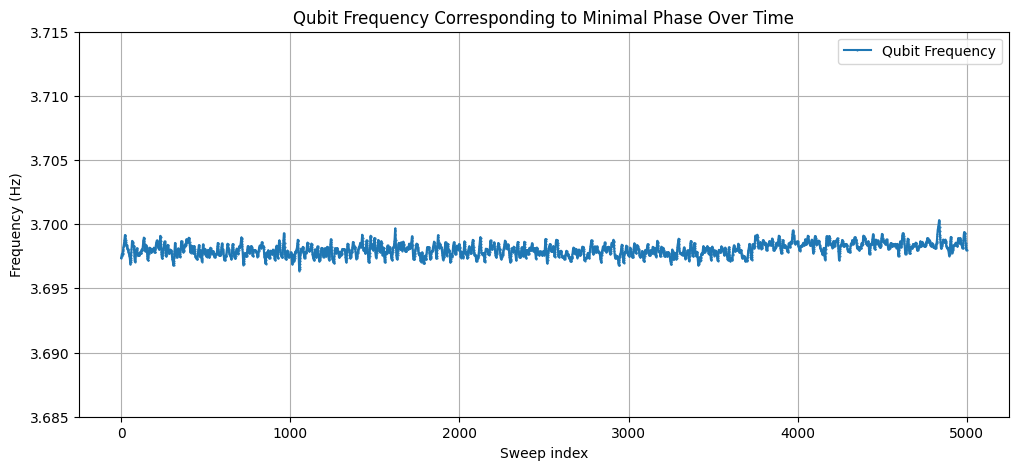

In [8]:
from fit_code.spectroscopy_1D_plot import spectroscopy_1D_plot

# start_idx, finish_idx = 0, 30000
# start_idx, finish_idx = 37000, 46000
# start_idx, finish_idx = 50000, 74000
start_idx, finish_idx = 81000, 86000

def plot_phase_minimal_phase(times_list, phase2D, qu_freq2D, sweep_param1D):


    time_sigma=3
    freq_sigma=3
    phase2D = gaussian_filter(phase2D, sigma=(time_sigma, freq_sigma))

    peak_fit = np.empty((-start_idx + finish_idx,4), float)

    qu_freq = qu_freq2D[0]*1e-9
    for run in tqdm(range(peak_fit.shape[0])):   
        data = np.array(phase2D[run][:]).T

        fig_fit, res_freq, FWHM = spectroscopy_1D_plot(qu_freq, data, xlabel='qu freq [GHz]', ylabel='phase', fit_enabled=True)
        plt.close()

        # if run>= 1 and abs(res_freq - peak_fit[run-1, 1]) > 5*(qu_freq[-1] - qu_freq[0])/(qu_freq.shape[0]-1):
        #     closest_idx = np.argmin(np.abs(qu_freq - peak_fit[run-1, 1]))
        #     range_idx = 5
        #     search_range = slice(
        #         max(closest_idx - range_idx, 0),
        #         min(closest_idx + range_idx + 0, qu_freq.shape[0]-1)
        #     )
        #     fig_fit, res_freq, FWHM = spectroscopy_1D_plot(qu_freq[search_range], data[search_range], xlabel='qu freq [GHz]', ylabel='phase', fit_enabled=True)
        #     plt.close()
        #     print(f"Adjusted to proximiiy search: {res_freq}")

        peak_fit[run] = [run, res_freq, FWHM, times_list[run]]

    # Plot the extracted qubit frequency curve over time (sweep_param)
    plt.figure(figsize=(12, 5))
    
    plt.plot(peak_fit[:, 0], peak_fit[:, 1], marker='.', linestyle='-', markersize=1, label="Qubit Frequency")
    
    # Apply smoothing using a rolling mean (window size = 10 for example)

    # window_size = 20
    # qu_freq_smooth = pd.Series(peak_fit[:, 1]).rolling(window=window_size, center=True).mean().dropna().values
    # trimmed_qubit_time = times_list[window_size//2 : -window_size//2]
    # qu_freq_smooth = qu_freq_smooth[:-1]  # Trim the last point
    # interp_qu_freq_smooth = interp1d(trimmed_qubit_time, qu_freq_smooth, kind='linear', fill_value="extrapolate")
    # qu_freq_smooth = interp_qu_freq_smooth(times_list)
    # plt.plot(peak_fit[:, 0], qu_freq_smooth, marker='.', linestyle='-', markersize=1, label="avg")

    plt.xlabel("Sweep index")
    plt.ylabel("Frequency (Hz)")
    plt.title("Qubit Frequency Corresponding to Minimal Phase Over Time")
    plt.legend()
    plt.grid(True)
    plt.ylim(3.685, 3.715)
    plt.show()

    return peak_fit


peak_fit = plot_phase_minimal_phase(times_list[start_idx:finish_idx], phase2D[start_idx:finish_idx], 
                         qu_freq2D[start_idx:finish_idx], sweep_param1D[start_idx:finish_idx])

In [9]:
np.save(os.path.join(folder_path, "2025-03-12_peak_fit_{}_{}.npy".format(start_idx, finish_idx)), peak_fit)

In [21]:
start_idx, finish_idx = 0, 30000
# start_idx, finish_idx = 37000, 46000
# start_idx, finish_idx = 50000, 74000
# start_idx, finish_idx = 81000, 86000
peak_fit = np.load(os.path.join(folder_path, "2025-03-12_peak_fit_{}_{}.npy".format(start_idx, finish_idx)))

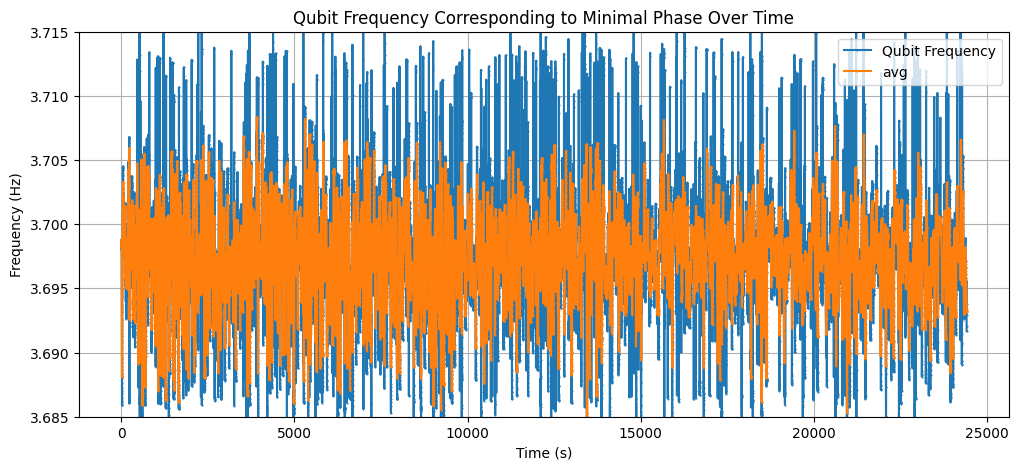

In [22]:
# Plot the extracted qubit frequency curve over time (sweep_param)
plt.figure(figsize=(12, 5))

plt.plot(peak_fit[:, 3], peak_fit[:, 1], marker='.', linestyle='-', markersize=1, label="Qubit Frequency")

# Apply smoothing using a rolling mean (window size = 10 for example)

window_size = 20
qu_freq_smooth = pd.Series(peak_fit[:, 1]).rolling(window=window_size, center=True).mean().dropna().values
trimmed_qubit_time = peak_fit[:, 3][window_size//2 : -window_size//2]
qu_freq_smooth = qu_freq_smooth[:-1]  # Trim the last point
interp_qu_freq_smooth = interp1d(trimmed_qubit_time, qu_freq_smooth, kind='linear', fill_value="extrapolate")
qu_freq_smooth = interp_qu_freq_smooth(peak_fit[:, 3])
plt.plot(peak_fit[:, 3], qu_freq_smooth, marker='.', linestyle='-', markersize=1, label="avg")

plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Qubit Frequency Corresponding to Minimal Phase Over Time")
plt.legend()
plt.grid(True)
plt.ylim(3.685, 3.715)
plt.show()

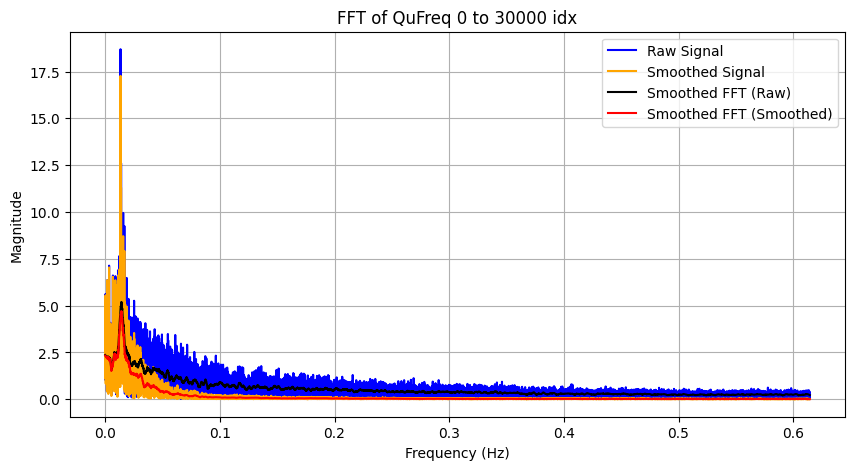

In [23]:
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Raw time and signals
time_array = peak_fit[:, 3]
signal_raw = peak_fit[:, 1]
signal_smooth = qu_freq_smooth  # Make sure this is the same length as time_array!

# Remove DC component
signal_raw = signal_raw - np.mean(signal_raw)
signal_smooth = signal_smooth - np.mean(signal_smooth)

# Create a uniform time grid
uniform_time = np.linspace(time_array.min(), time_array.max(), len(time_array))

# Interpolate both signals onto this grid
interp_raw = interp1d(time_array, signal_raw, kind='linear', fill_value="extrapolate")
interp_smooth = interp1d(time_array, signal_smooth, kind='linear', fill_value="extrapolate")

uniform_raw = interp_raw(uniform_time)
uniform_smooth = interp_smooth(uniform_time)

# Compute FFT
dt = uniform_time[1] - uniform_time[0]
fft_raw = fft(uniform_raw)
fft_smooth = fft(uniform_smooth)
freqs = fftfreq(len(uniform_time), d=dt)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], np.abs(fft_raw[:len(freqs)//2]), label="Raw Signal", color="b")
plt.plot(freqs[:len(freqs)//2], np.abs(fft_smooth[:len(freqs)//2]), label="Smoothed Signal", color="orange")

# Smooth FFT magnitudes (only the real part)
fft_raw_mag = np.abs(fft_raw[:len(freqs)//2])
fft_smooth_mag = np.abs(fft_smooth[:len(freqs)//2])

# Apply Savitzky-Golay filter (window length must be odd and < data length)
smoothed_raw = savgol_filter(fft_raw_mag, window_length=101, polyorder=2)
smoothed_smooth = savgol_filter(fft_smooth_mag, window_length=101, polyorder=2)

plt.plot(freqs[:len(freqs)//2], smoothed_raw, label="Smoothed FFT (Raw)", color="black")
plt.plot(freqs[:len(freqs)//2], smoothed_smooth, label="Smoothed FFT (Smoothed)", color="red")


plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
# plt.yscale("log")
plt.title(f"FFT of QuFreq {start_idx} to {finish_idx} idx")
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(folder_path, "FFT_{}_{}.pdf".format(start_idx, finish_idx)))
plt.show()


In [25]:
freqs[:len(freqs)//2][np.argmax(smoothed_raw)]

0.014175444041793588

In [29]:
def calc(current):

    k = (3.7029 - 3.7907) / (26 - 19)

    freq = k * (current - 19) + 3.7907

    return freq - 0.1, freq + 0.1

calc(41.8)

(3.404722857142857, 3.6047228571428573)

In [15]:
-(-267.8) + 18.2

286.0